In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import utils
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 96

train_path = "dataset\\training_set"
test_path = "dataset\\test_set"

## Prepare train and test examples

In [3]:
x_train, y_train = utils.create_set(train_path,IMG_SIZE)

In [4]:
x_val, y_val = utils.create_set(test_path,IMG_SIZE)

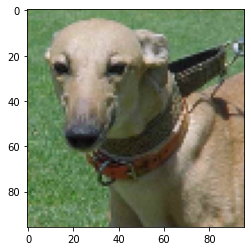

In [5]:
image = x_train[0]
rgb_image = image[...,::-1] # BGR to RGB
plt.imshow(rgb_image)

## Model

In [28]:
def conv_block(x,channels):
    x = tf.keras.layers.Conv2D(channels, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.Conv2D(channels, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    return x

In [29]:
def conv_block_simple(x,channels):
    x = tf.keras.layers.Conv2D(channels, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    return x

In [13]:
def create_model(IMG_SIZE):
    inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))

    x = conv_block_simple(inputs,16)
    x = conv_block_simple(x,32)
    x = conv_block_simple(x,64)
    x = conv_block_simple(x,128)
    #x = conv_block_simple(x,256)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(256, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.8)(x)
    outputs = tf.keras.layers.Dense(2, activation = 'softmax')(x)

    return tf.keras.Model(inputs = inputs, outputs = outputs)

In [59]:
def create_model(IMG_SIZE):
    inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))

    x = conv_block(inputs,16)
    x = conv_block(x,32)
    x = conv_block(x,64)
    x = conv_block(x,128)
    x = conv_block_simple(x,256)
    #x = conv_block(x,512)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(2, activation = 'softmax')(x)

    return tf.keras.Model(inputs = inputs, outputs = outputs)

In [6]:
def create_model(IMG_SIZE):
    inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))

    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                                kernel_initializer = tf.keras.initializers.HeUniform())(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                                kernel_initializer = tf.keras.initializers.HeUniform())(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                              kernel_initializer = tf.keras.initializers.HeUniform(), 
                              kernel_regularizer = tf.keras.regularizers.l2(l2=0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                              kernel_initializer = tf.keras.initializers.HeUniform(), 
                              kernel_regularizer = tf.keras.regularizers.l2(l2=0.01,))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                              kernel_initializer = tf.keras.initializers.HeUniform(), 
                              kernel_regularizer = tf.keras.regularizers.l2(l2=0.01,))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Flatten()(x)

    outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

    return tf.keras.Model(inputs = inputs, outputs = outputs)

In [7]:
model = create_model(IMG_SIZE)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 94, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 45, 45, 128)       512   

## Training

In [9]:
# I applied some in-flow data augmentation. 
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #rotation_range=45,
    #zoom_range=0.1,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=10,
    horizontal_flip=True,
    vertical_flip=True,
    rescale = 1./255,
    fill_mode="nearest")

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001, momentum= 0.9)
model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
callbacks_list

In [11]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=128,shuffle = True),
    epochs = 30, 
    shuffle = True, 
    validation_data = (x_val, y_val))

Epoch 1/30
180/180 [==============================] - 44s 204ms/step - loss: 6.4348 - accuracy: 0.5844 - val_loss: 2.5067 - val_accuracy: 0.5070
Epoch 2/30
180/180 [==============================] - 34s 191ms/step - loss: 1.4277 - accuracy: 0.6563 - val_loss: 1.5507 - val_accuracy: 0.5500
Epoch 3/30
180/180 [==============================] - 34s 191ms/step - loss: 0.8593 - accuracy: 0.7006 - val_loss: 3.4932 - val_accuracy: 0.5819
Epoch 4/30
180/180 [==============================] - 34s 191ms/step - loss: 0.7716 - accuracy: 0.7337 - val_loss: 13.9995 - val_accuracy: 0.5754
Epoch 5/30
180/180 [==============================] - 35s 192ms/step - loss: 0.7280 - accuracy: 0.7595 - val_loss: 48.6121 - val_accuracy: 0.5534
Epoch 6/30
180/180 [==============================] - 35s 192ms/step - loss: 0.7097 - accuracy: 0.7767 - val_loss: 190.2593 - val_accuracy: 0.5000
Epoch 7/30
180/180 [==============================] - 35s 192ms/step - loss: 0.7000 - accuracy: 0.7824 - val_loss: 63.4906 - v

KeyboardInterrupt: 

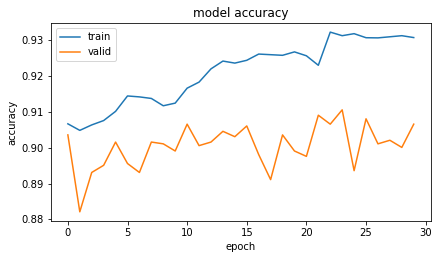

In [22]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history2.history['accuracy'])  
plt.plot(history2.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [32]:
model.evaluate(datagen.flow(x_test, y_test, batch_size=128))

16/16 [==============================] - 4s 247ms/step - loss: 0.3816 - accuracy: 0.8866


[0.38159435987472534, 0.8866133689880371]

## Test

In [72]:
tescik_path = "dataset\\test_set"

def create_tescik(train_path, label):
    x_train = []
    y_train = []
    cats_path = train_path + "\\tescik_" + label
    for img_path in os.listdir(cats_path):
        try:
            img_path = os.path.join(cats_path,img_path)
            img = cv2.resize(cv2.imread(img_path), (IMG_SIZE,IMG_SIZE))
            x_train.append(img)
            if (label == "cats"): y_train.append(0)
            else: y_train.append(1)
            
        except: None

    return np.array(x_train)/255.0, np.array(y_train)

In [73]:
x_dogs, y_dogs = create_tescik(tescik_path, "dogs")
x_cats, y_cats = create_tescik(tescik_path, "cats")
x_test = np.concatenate((x_dogs,x_cats),axis=0)
y_test = np.concatenate((y_dogs,y_cats),axis=0)

In [109]:
# I applied some in-flow data augmentation. 
aug_rate = 0.1
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20*aug_rate,
    zoom_range=0.1*aug_rate,
    width_shift_range=0.1*aug_rate,
    height_shift_range=0.1*aug_rate,
    shear_range=10*aug_rate,
    horizontal_flip=True,
    fill_mode="nearest")

In [110]:
out = model.predict(val_gen.flow(x_test, shuffle=False))
predicted = np.argmax(out, axis=-1)

for i in range(9):
    out = model.predict(val_gen.flow(x_test, shuffle=False))
    predicted += np.argmax(out, axis=-1)

In [102]:
out = model.predict(x_test)
predicted = np.argmax(out, axis=-1)

In [111]:
compared = list(zip(y_test*10,predicted))
[(idx,abs(i[0]-i[1])) for idx,i in enumerate(compared)]

[(0, 0),
 (1, 1),
 (2, 10),
 (3, 3),
 (4, 10),
 (5, 8),
 (6, 9),
 (7, 0),
 (8, 7),
 (9, 0),
 (10, 1),
 (11, 10),
 (12, 9),
 (13, 8),
 (14, 10),
 (15, 0),
 (16, 9),
 (17, 3),
 (18, 8),
 (19, 2),
 (20, 0),
 (21, 3),
 (22, 2),
 (23, 10),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 0),
 (37, 0),
 (38, 0),
 (39, 0),
 (40, 0),
 (41, 0),
 (42, 0),
 (43, 0),
 (44, 0),
 (45, 0),
 (46, 0)]

1


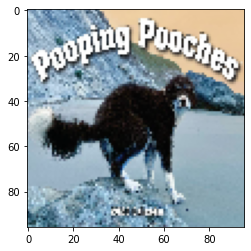

In [185]:
idx = 14
print(y_test[idx])
plt.imshow(x_test[idx])